In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
from gym import Env, spaces
from qpython import qconnection
import numpy as np
import json
import pandas as pd 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
def _exec(qry, pandas=False):
        with qconnection.QConnection(
            host="localhost", 
            port=5050, 
            pandas=pandas) as q:
            return q.sendSync(qry) 

In [23]:
q="""
sizeMultiplier:1;
priceMultiplier:100;
tab:7;
deriveo:{[u]
    r:u[`resp];
    d:first r[`data];
    time:"Z"$d[`timestamp];
    a:"F"$(r[`data][`asks][0]); 
    b:"F"$(r[`data][`bids][0]); // TODO if count is greater than one.
    ca:count[a];
    cb:count[b];
    cab:ca+cb; 
    $[(ca>0) and (cb>0);
      :(cab#time;cab#u[`utc_time];((ca#`SELL),(cb#`BUY));`int$((a[;0],b[;0])*priceMultiplier);`int$((a[;1],b[;1])));
      ca>0;
      :(ca#time;ca#u[`utc_time];(ca#`SELL);`int$(a[;0]*priceMultiplier);`int$(a[;1]));
      cb>0;
      :(cb#time;cb#u[`utc_time];(cb#`BUY);`int$(b[;0]*priceMultiplier);`int$(b[;1]));
    ];   
};
x:deriveo each (select from depth where utc_time within(min[utc_time];(min[utc_time]+(`minute$30))));
x:flip `time`intime`side`price`size!raze each flip x;
/ `.okex.tab set x;
x:delete from x where[(type each exec size from x)=101h];

(`time xasc x)
"""
orderbook = _exec(q,pandas=True)

In [32]:
grd2=pd.pivot_table(orderbook, values =["size"], index=['time'], columns = ["price"]).reset_index()

In [33]:
grd2.fillna(0,inplace=True)

In [10]:
grd2.shape

(31456, 2030)

In [34]:
grd2=grd2["size"][:1000]

In [35]:
grd2=np.array(grd2.transpose())

In [36]:
grd2=grd2/np.sum(grd2,axis=0)

In [37]:
grd2.shape

(2029, 1000)

In [4]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import numpy as np

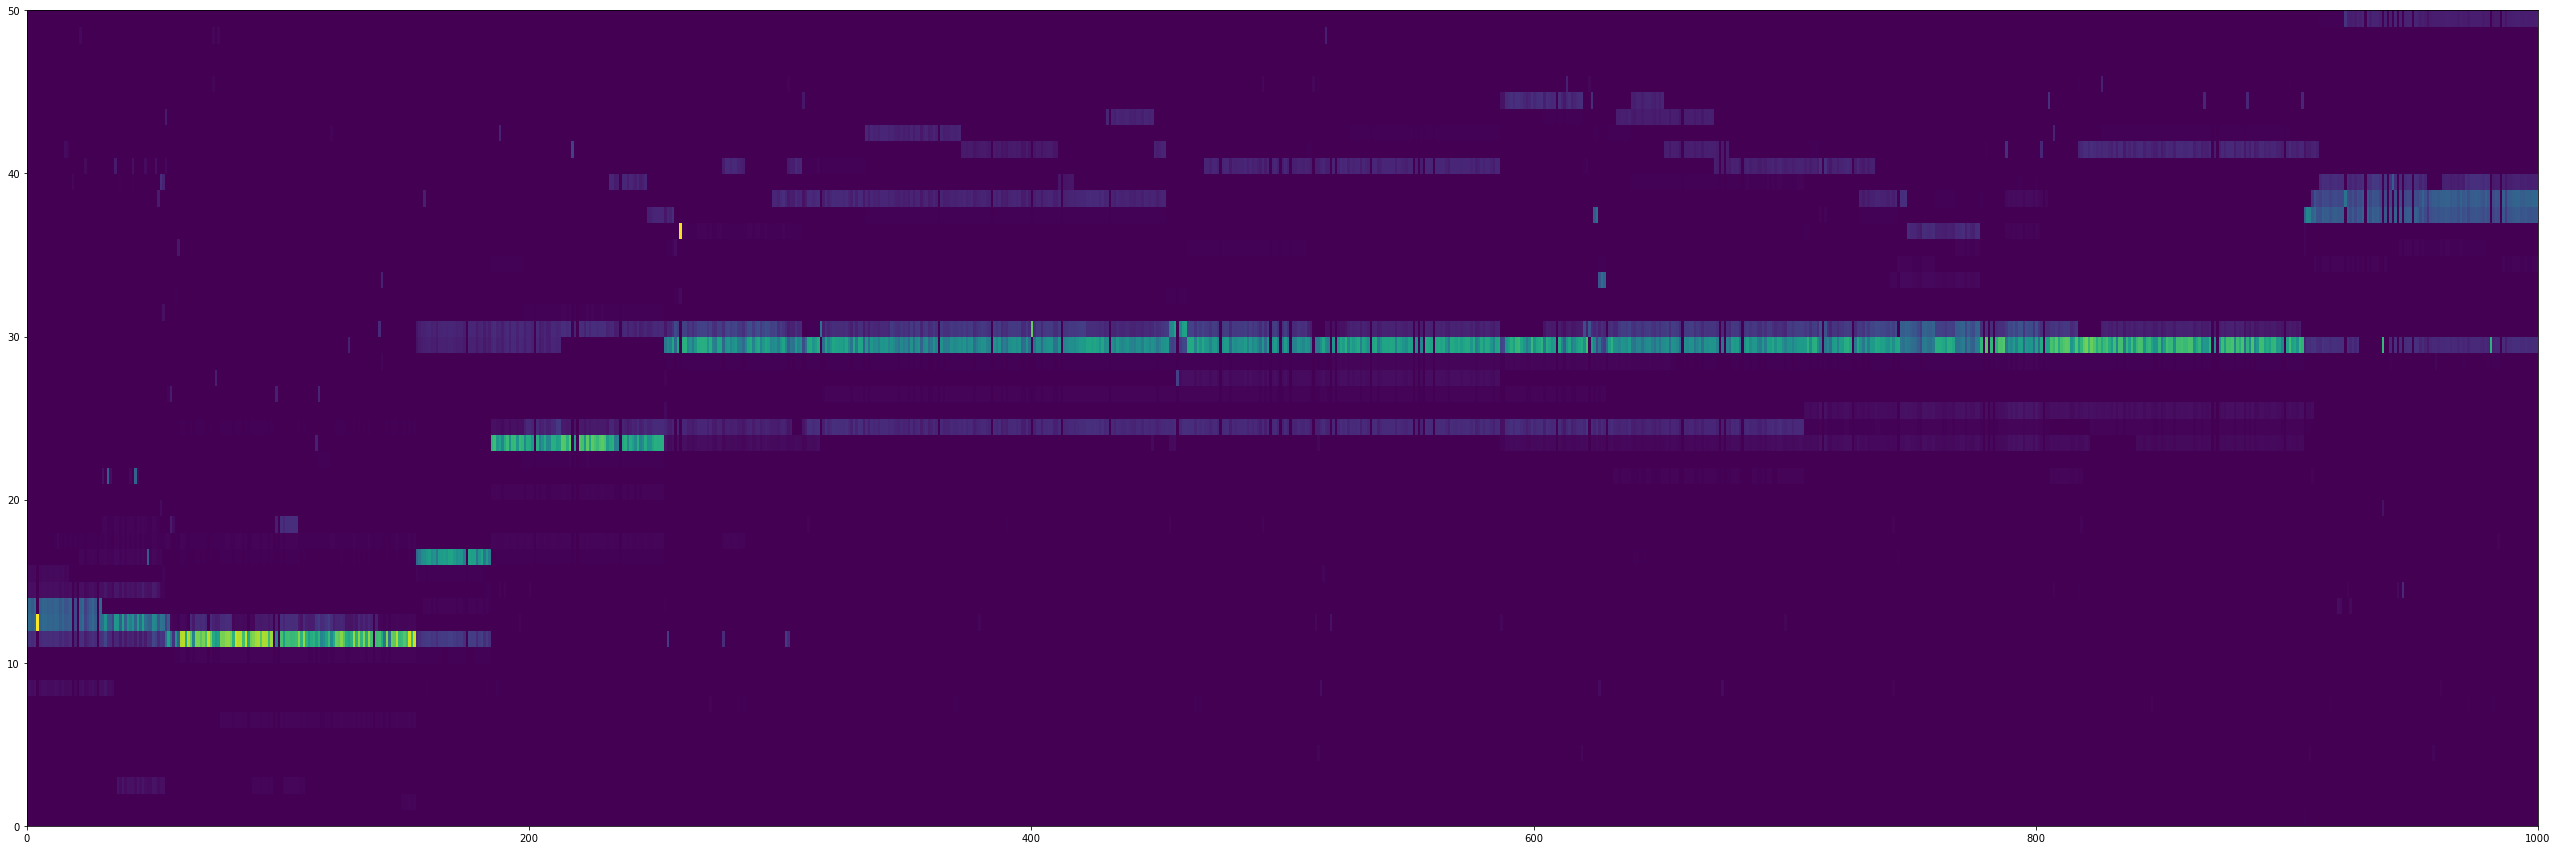

In [16]:
x = np.arange(1001)  # len = 11
y = np.arange(51)  # len = 7

fig, ax = plt.subplots(figsize=(45,15))
ax.pcolormesh(x, y, grd2[1000:1050])

In [17]:
import plotly.graph_objects as go

import pandas as pd
from datetime import datetime

In [ ]:
tradeParser:{[u]
    
    x: derive each u;
    x:flip raze each flip x;
    cx:count x;
    :flip `time`intime`kind`cmd`datum!(x[;0];x[;1];cx#`TRADE;cx#`NEW;(x[;2+til 3]));
    };

In [20]:
q="""
sizeMultiplier:1;
priceMultiplier:100;
tab:7;
derivet:{
        d:x[`resp][`data][0]; 
        :`time`intime`side`price`size!("Z"$d[`timestamp]; x[`utc_time];$[d[`side]~"sell"; `SELL; `BUY];`int$(("F"$d[`price])*priceMultiplier);`int$(("F"$d[`size])*sizeMultiplier));
    };
x:derivet each (select from trade where utc_time within(min[utc_time];(min[utc_time]+(`minute$30))));
x:flip raze each flip x;

(`time xasc x)
"""
trade = _exec(q,pandas=True)

In [21]:
trade

,time,intime,side,price,size
0,2020-07-26 23:35:58.116,2020-07-26 23:35:58.221,b'BUY',993410,10
1,2020-07-26 23:36:24.168,2020-07-26 23:36:24.288,b'BUY',993410,10
2,2020-07-26 23:36:28.082,2020-07-26 23:36:28.227,b'BUY',993410,29
3,2020-07-26 23:36:28.082,2020-07-26 23:36:28.228,b'BUY',993410,22
4,2020-07-26 23:36:28.082,2020-07-26 23:36:28.232,b'BUY',993410,18
...,...,...,...,...,...
3263,2020-07-27 00:29:51.298,2020-07-27 00:29:51.423,b'BUY',997000,200
3264,2020-07-27 00:29:51.298,2020-07-27 00:29:51.427,b'BUY',997000,11
3265,2020-07-27 00:29:51.616,2020-07-27 00:29:51.733,b'BUY',997000,1
3266,2020-07-27 00:29:51.616,2020-07-27 00:29:51.736,b'BUY',997000,1
